In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import plotly.express as px
import plotly.io as pio
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sqlalchemy import create_engine
import logging

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
pd.set_option("display.float_format", "{:.2f}".format)

In [ ]:
# Connect to your Postgres database
engine = create_engine("postgresql://mojo@localhost:5432/houston311db")

# Load the table into a DataFrame
df = pd.read_sql("SELECT * FROM houston_311", engine)

pio.renderers.default = "notebook_connected"

In [3]:
df.describe

<bound method NDFrame.describe of                    CASE NUMBER                                 NEIGHBORHOOD  \
0        12091834-101002444724                 EAST LITTLE YORK / HOMESTEAD   
1        12091835-101002444725                          NORTHSIDE/NORTHLINE   
2                 101002444726                                     MID WEST   
3                 101002444727  WASHINGTON AVENUE COALITION / MEMORIAL PARK   
4        12091836-101002444730                               GREATER UPTOWN   
...                        ...                                          ...   
3800664      217348-2400490914                                     WESTBURY   
3800665    12670427-2400490912                    GREATER OST / SOUTH UNION   
3800666             2400490911                                        ALIEF   
3800667    20480340-2400490910                                   NORTHSHORE   
3800668    12670426-2400490909                          NORTHSIDE/NORTHLINE   

                 

In [4]:
df.dtypes

CASE NUMBER                     object
NEIGHBORHOOD                    object
DEPARTMENT                      object
DIVISION                        object
CASE TYPE                       object
CREATED DATE            datetime64[ns]
CLOSED DATE             datetime64[ns]
LATITUDE                       float64
LONGITUDE                      float64
CATEGORY                        object
RESOLUTION_TIME_DAYS           float64
dtype: object

In [5]:
cols = ["NEIGHBORHOOD", "DEPARTMENT", "DIVISION", "CATEGORY", "CASE TYPE"]

for c in cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .str.title()
        .str.replace("\s+", " ", regex=True)
    )

In [ ]:
# Aggregate by month
overall_ts = (
    df.groupby(pd.Grouper(key='CREATED DATE', freq='ME'))
      .size()
      .reset_index(name='y')
      .rename(columns={'CREATED DATE': 'ds'})
)

# Remove months with too few rows
cleaned_ts = overall_ts[overall_ts["y"] > 1000] 

# Determine the last fully complete month
last_month = cleaned_ts['ds'].max()
cleaned_ts = cleaned_ts[cleaned_ts['ds'] < last_month]

# Fit Prophet
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(cleaned_ts)

# Forecast next 12 months
future = m.make_future_dataframe(periods=12, freq='ME')
forecast = m.predict(future)

00:47:23 - cmdstanpy - INFO - Chain [1] start processing
00:47:23 - cmdstanpy - INFO - Chain [1] done processing


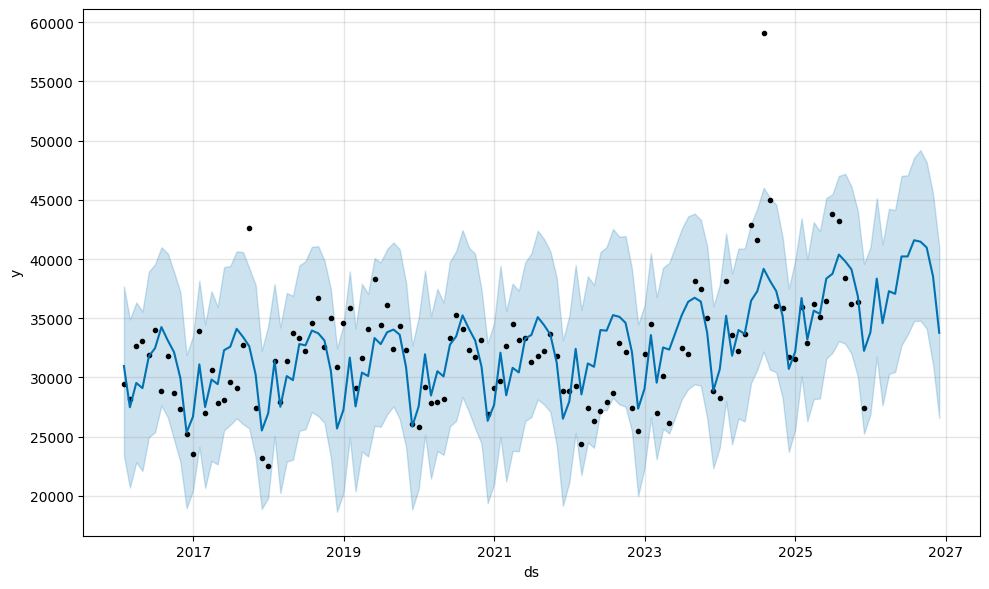

In [7]:
plot1 = m.plot(forecast)

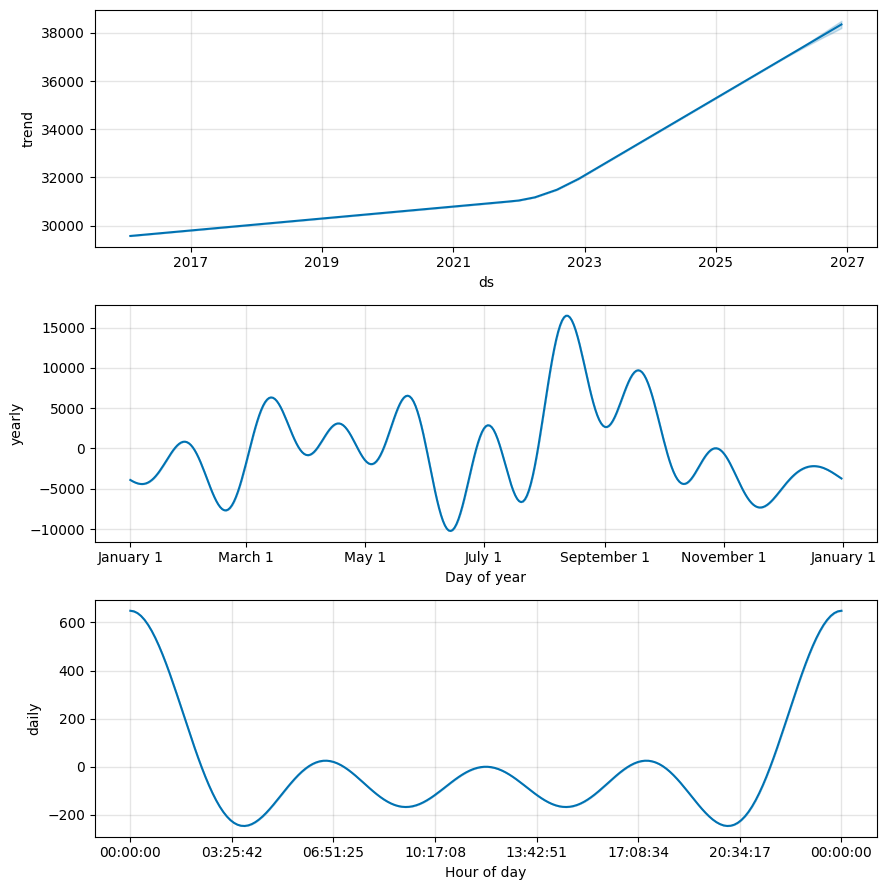

In [8]:
plot2 = m.plot_components(forecast)

In [9]:
# Merge forecasted values with actuals
results = cleaned_ts.merge(forecast, on='ds', how='left')

# Keep only training portion (historical)
historical = results[results['ds'] <= cleaned_ts['ds'].max()]

In [10]:
# Calculate error metrics
y_true = historical['y']
y_pred = historical['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  2588.99
RMSE: 3586.15
MAPE: 7.97%


In [11]:
# Keep only periods that exist in your original data
actual = cleaned_ts.set_index("ds")
predicted = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]

# Join actuals with predictions
compare = actual.join(predicted, how="left")

# Compute residuals (errors)
compare["error"] = compare["y"] - compare["yhat"]
compare.head()

,y,yhat,yhat_lower,yhat_upper,error
ds,,,,,
2016-01-31,29448,30967.410553,23414.917500,37680.547094,-1519.410553
2016-02-29,28153,27481.095560,20699.776247,34899.221755,671.904440
2016-03-31,32681,29537.457875,22835.125922,36330.239803,3143.542125
2016-04-30,33048,29099.136432,22106.863006,35569.408891,3948.863568
2016-05-31,31904,31781.678457,24955.191598,38943.444399,122.321543


In [12]:
bias = compare["error"].mean()
print("Mean Bias:", bias)

Mean Bias: -0.6266609634435785


In [13]:
compare["month"] = compare.index.month
monthly_bias = compare.groupby("month")["error"].mean()
print(monthly_bias)

month
1     16.592161
2     26.378355
3     16.082305
4      0.437701
5    -31.770342
6    -40.383139
7    -19.506165
8     -2.451750
9     -7.555971
10    -5.354752
11    15.148024
12    24.235490
Name: error, dtype: float64


In [14]:
category_col = "NEIGHBORHOOD"
date_col = "CREATED DATE"  

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

00:47:27 - cmdstanpy - INFO - Chain [1] start processing
00:47:27 - cmdstanpy - INFO - Chain [1] done processing
00:47:27 - cmdstanpy - INFO - Chain [1] start processing
00:47:27 - cmdstanpy - INFO - Chain [1] done processing
00:47:28 - cmdstanpy - INFO - Chain [1] start processing
00:47:28 - cmdstanpy - INFO - Chain [1] done processing
00:47:28 - cmdstanpy - INFO - Chain [1] start processing
00:47:28 - cmdstanpy - INFO - Chain [1] done processing
00:47:28 - cmdstanpy - INFO - Chain [1] start processing
00:47:29 - cmdstanpy - INFO - Chain [1] done processing
00:47:29 - cmdstanpy - INFO - Chain [1] start processing
00:47:29 - cmdstanpy - INFO - Chain [1] done processing
00:47:29 - cmdstanpy - INFO - Chain [1] start processing
00:47:29 - cmdstanpy - INFO - Chain [1] done processing
00:47:29 - cmdstanpy - INFO - Chain [1] start processing
00:47:30 - cmdstanpy - INFO - Chain [1] done processing
00:47:30 - cmdstanpy - INFO - Chain [1] start processing
00:47:30 - cmdstanpy - INFO - Chain [1]

                                       Category         MAE        RMSE  \
43                         Independence Heights   37.238415   51.808507   
83  Washington Avenue Coalition / Memorial Park   84.995931  102.948992   
52                      Meadowbrook / Allendale   32.786755   36.201802   
82                             University Place   41.557992   70.249428   
32                               Greater Inwood   45.446969   65.151876   
77                           Spring Branch East   38.538495   48.036624   
71                                   Sharpstown   46.077748   53.772831   
63                                         None   49.228573   57.549560   
48                           Lawndale / Wayside   21.967386   24.159006   
35                               Greater Uptown   57.196733   65.712300   
5                                      Braeburn   18.136674   19.839024   
26              Golfcrest / Bellfort / Reveille   87.015669  113.048639   
11                       

In [15]:
category_col = "DEPARTMENT" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:04 - cmdstanpy - INFO - Chain [1] start processing
00:48:04 - cmdstanpy - INFO - Chain [1] done processing
00:48:05 - cmdstanpy - INFO - Chain [1] start processing
00:48:05 - cmdstanpy - INFO - Chain [1]

                                 Category          MAE         RMSE  \
16                           Public Works  1145.430490  1706.507948   
14                     Parking Management   104.733507   120.930847   
7                                  Health    47.559662    54.011574   
17                 Solid Waste Management  2647.338936  3439.319954   
15                   Parks And Recreation   139.913509   145.691958   
12                           Mayor Office   131.346420   147.095023   
4                                 Finance     5.989196     6.316722   
5                        Fleet Management     1.614781     2.115145   
0                            311 Helpline  1073.049208  1160.492564   
9                 Houston Fire Department   124.263485   176.120326   
3                       External Referral    30.680385    30.783486   
13                          Neighborhoods  1767.691939  1980.974862   
8           Housing Community Development    43.010039    51.847285   
10    

In [16]:
category_col = "DIVISION" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

00:48:18 - cmdstanpy - INFO - Chain [1] start processing
00:48:18 - cmdstanpy - INFO - Chain [1] done processing
00:48:18 - cmdstanpy - INFO - Chain [1] start processing
00:48:18 - cmdstanpy - INFO - Chain [1] done processing
00:48:19 - cmdstanpy - INFO - Chain [1] start processing
00:48:19 - cmdstanpy - INFO - Chain [1] done processing
00:48:20 - cmdstanpy - INFO - Chain [1] start processing
00:48:20 - cmdstanpy - INFO - Chain [1] done processing
00:48:20 - cmdstanpy - INFO - Chain [1] start processing
00:48:20 - cmdstanpy - INFO - Chain [1] done processing
00:48:21 - cmdstanpy - INFO - Chain [1] start processing
00:48:21 - cmdstanpy - INFO - Chain [1] done processing
00:48:21 - cmdstanpy - INFO - Chain [1] start processing
00:48:21 - cmdstanpy - INFO - Chain [1] done processing
00:48:21 - cmdstanpy - INFO - Chain [1] start processing
00:48:21 - cmdstanpy - INFO - Chain [1] done processing
00:48:21 - cmdstanpy - INFO - Chain [1] start processing
00:48:21 - cmdstanpy - INFO - Chain [1]

                              Category          MAE         RMSE    MAPE (%)
28                 Parking Enforcement    93.865703   111.821479    7.340513
3                          Collections   731.441921   908.462315    7.826650
38  Transportation Drainage Operations   483.702808   617.460100    8.627063
20                       Houston Water   668.681798   808.619309   10.555450
11                Environmental Health    47.443082    53.743405   11.783466
12          Facilities And Maintenance    12.897910    14.314295   14.855077
33           Public Information Office     7.263407     9.859410   14.908665
22                      Investigations   235.777564   294.497323   16.853966
18               Greenspace Management    34.168528    47.645940   16.867322
24                          Mayor Mail   118.950706   135.970287   23.127871
27                           Occupancy     4.600754     6.700750   24.545848
36                           Recycling  1566.621509  2726.706434   27.308347

In [17]:
category_col = "CATEGORY" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

00:48:37 - cmdstanpy - INFO - Chain [1] start processing
00:48:37 - cmdstanpy - INFO - Chain [1] done processing
00:48:37 - cmdstanpy - INFO - Chain [1] start processing
00:48:37 - cmdstanpy - INFO - Chain [1] done processing
00:48:38 - cmdstanpy - INFO - Chain [1] start processing
00:48:38 - cmdstanpy - INFO - Chain [1] done processing
00:48:38 - cmdstanpy - INFO - Chain [1] start processing
00:48:38 - cmdstanpy - INFO - Chain [1] done processing
00:48:39 - cmdstanpy - INFO - Chain [1] start processing
00:48:39 - cmdstanpy - INFO - Chain [1] done processing
00:48:39 - cmdstanpy - INFO - Chain [1] start processing
00:48:39 - cmdstanpy - INFO - Chain [1] done processing
00:48:39 - cmdstanpy - INFO - Chain [1] start processing
00:48:39 - cmdstanpy - INFO - Chain [1] done processing
00:48:40 - cmdstanpy - INFO - Chain [1] start processing
00:48:40 - cmdstanpy - INFO - Chain [1] done processing
00:48:41 - cmdstanpy - INFO - Chain [1] start processing
00:48:41 - cmdstanpy - INFO - Chain [1]

                               Category          MAE         RMSE    MAPE (%)
17                   Sewer & Wastewater    96.045053   113.722104    7.490639
16            Road & Street Maintenance   163.411707   208.055522    7.603991
11                  Parking Enforcement   104.733507   120.930847    7.985410
1                 Animal & Pest Control    51.812250    68.845048    9.252505
12                   Parks & Recreation    31.657371    48.636718   10.850594
14  Public Infrastructure / Engineering    34.796809    41.842863   11.760457
24                Water Service & Leaks   775.328739   910.794464   14.788510
5             Environmental & Pollution    15.027830    17.649921   16.457849
2           Building & Code Enforcement   185.659577   230.912690   17.125756
20              Traffic Signals & Signs   418.538147   499.508877   17.134018
22                    Trash & Recycling  2360.249942  3281.803436   19.130609
19                      Street Lighting    10.186044    12.72122

In [18]:
cap = df["RESOLUTION_TIME_DAYS"].quantile(0.95)
df["RESOLUTION_TIME_DAYS"] = df["RESOLUTION_TIME_DAYS"].clip(upper=cap)

In [23]:
# Find the two most recent months in your data
latest_date = df["CREATED DATE"].max()
latest_month_start = latest_date.replace(day=1)
second_latest_month_start = (latest_month_start - pd.DateOffset(months=1))

# Keep only rows before these two months
df_model = df[df["CREATED DATE"] < second_latest_month_start].copy()


In [26]:
# Median per case type (can contain NaN)
medians_by_type = df_model.groupby('CASE TYPE')['RESOLUTION_TIME_DAYS'].median()

# Map case-type median to rows
df_model['MEDIAN_BY_TYPE'] = df_model['CASE TYPE'].map(medians_by_type)

# Fill missing durations ONLY where case-type median exists
df_model['RESOLUTION_TIME_DAYS'] = df_model.apply(
    lambda row: row['MEDIAN_BY_TYPE'] if pd.isna(row['RESOLUTION_TIME_DAYS']) and not pd.isna(row['MEDIAN_BY_TYPE'])
    else row['RESOLUTION_TIME_DAYS'],
    axis=1
)

# Drop rows where RESOLUTION_TIME_DAYS is still NaN AND the case type median was also NaN
df_model = df_model.dropna(subset=['RESOLUTION_TIME_DAYS'])

In [65]:
# Case volume per month
monthly_volume = (
    df_model
    .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
    .size()
    .reset_index(name="case_volume")
)

# Dominant case-type proportion
case_type_monthly = (
    df_model
    .groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
    .size()
    .reset_index(name="count")
)

month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)

dominant_prop = (
    case_type_monthly
    .sort_values(["CREATED DATE", "prop"], ascending=[True, False])
    .groupby("CREATED DATE")
    .first()
    .reset_index()[["CREATED DATE", "prop"]]
    .rename(columns={"prop": "dominant_case_prop"})
)


# BUILD FORECASTING TS (y + regressors)
ts = (
    df_model
    .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
    .mean()
    .reset_index()
    .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
)

# Merge regressors
ts = (
    ts
    .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
)


# INTERPOLATE MISSING MONTHS (critical for regressors)
full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")

ts = ts.set_index("ds").reindex(full_range)

for col in ["y", "case_volume", "dominant_case_prop"]:
    ts[col] = ts[col].interpolate().bfill().ffill()

ts = ts.rename_axis("ds").reset_index()


# TRAIN/TEST SPLIT
ts = ts[ts["ds"] < pd.Timestamp("2025-11-01")]
train = ts[ts['ds'] >= '2022-01-01']
# train = ts.iloc[:-6]
test = ts.iloc[-6:]


# PROPHET WITH REGRESSORS

model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.8,
)

model.add_regressor("case_volume")
model.add_regressor("dominant_case_prop")

model.fit(train)

# Build future df with regressors\
future = model.make_future_dataframe(periods=12, freq="ME")
future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]],
                      on="ds", how="left")

# Forward-fill for future months
future["case_volume"] = future["case_volume"].ffill()
future["dominant_case_prop"] = future["dominant_case_prop"].ffill()

forecast = model.predict(future)

pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")

mape = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
fig = px.line(train, x='ds', y='y', title='Resolution Time Forecast', labels={'y':'Resolution Days'})
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines+markers', name='Actual')

# Plot predictions on test set (if desired)
fig.add_scatter(x=pred['ds'], y=pred['yhat'], mode='lines', name='Forecast (Test)')

# Plot future predictions
future_forecast = forecast[forecast['ds'] > train['ds'].max()]
fig.add_scatter(x=future_forecast['ds'], y=future_forecast['yhat'], mode='lines+markers', 
                name='Forecast (Future)', line=dict(dash='dash', color='red'))

fig.show()

MAPE: 5.93%


In [66]:
groups = df_model["NEIGHBORHOOD"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["NEIGHBORHOOD"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df


,MAPE
Macgregor,7.70
Denver Harbor / Port Houston,7.99
Lake Houston,9.11
Eastex - Jensen Area,12.89
Downtown,12.99
Greater Fifth Ward,13.35
South Acres / Crestmont Park,13.47
East Houston,14.36
Kashmere Gardens,14.43
Magnolia Park,14.64


In [67]:
groups = df_model["DEPARTMENT"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["DEPARTMENT"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
print(mape_df)

                                                        MAPE
Parking Management                                     12.52
External Referral                                      16.69
Emergency Management                                   20.36
Solid Waste Management                                 23.23
General Services                                       28.26
Finance                                                31.23
Public Works                                           42.73
Parks And Recreation                                   43.18
Legal                                                  72.05
Mayor Office                                           73.10
Houston Fire Department                                82.20
Health                                                 83.26
Houston Police Department                              90.24
311 Helpline                                          166.84
Fleet Management                                      273.31
Housing Community Develo

In [68]:
groups = df_model["DIVISION"].unique()
mape_results = {}
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

for g in groups:
    subset = df_model[df_model["DIVISION"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df

,MAPE
Investigations,4.89
Communications,5.04
Preparedness,7.25
Parking Enforcement,11.89
Parking Meter Maintenance,18.46
Capitol Improvement Planning,20.35
Transportation Drainage Operations,23.22
Collections,27.50
Security Management,28.26
Disaster Recovery,29.91


In [64]:
groups = df_model["CATEGORY"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["CATEGORY"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df

,MAPE
Parking Enforcement,12.52
Storm Damage & Disaster Recovery,12.69
Street Lighting,31.08
Trash & Recycling,34.97
Traffic Signals & Signs,34.99
Animal & Pest Control,40.46
Neighborhood Services,66.65
Heavy Trash & Code Violations,67.64
Road & Street Maintenance,67.65
Building & Code Enforcement,70.99
